# Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Import Review Data

## Metadata and raw text

In [6]:
review_meta_train = pd.read_csv('review_meta_train.csv')
review_text_train = pd.read_csv('review_text_train.csv')

In [7]:
review_meta_test =  pd.read_csv('review_meta_test.csv')
review_text_test = pd.read_csv('review_text_test.csv')


In [8]:
# Retrieve labels
y = review_meta_train['rating'].to_numpy()
print(y.shape)

(28068,)


## Features derived from review text

In [9]:
# Dictionary

vocab = pickle.load(open("train_countvectorizer.pkl", "rb"))

# retrieve dictionary:
# vocab.vocabulary_

C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Doc2Vec Features

from scipy import sparse

count_train = scipy.sparse.load_npz('review_text_train_vec.npz')
count_test = scipy.sparse.load_npz('review_text_test_vec.npz')

d2v50_train = pd.read_csv(r"review_text_train_doc2vec50.csv", 
                          index_col = False, delimiter = ',', header=None)
d2v50_test = pd.read_csv(r"review_text_test_doc2vec50.csv", 
                         index_col = False, delimiter = ',', header=None)

d2v100_train = pd.read_csv(r"review_text_train_doc2vec100.csv", 
                           index_col = False, delimiter = ',', header=None)
d2v100_test = pd.read_csv(r"review_text_test_doc2vec100.csv", 
                          index_col = False, delimiter = ',', header=None)

d2v200_train = pd.read_csv(r"review_text_train_doc2vec200.csv", 
                           index_col = False, delimiter = ',', header=None)
d2v200_test = pd.read_csv(r"review_text_test_doc2vec200.csv", 
                          index_col = False, delimiter = ',', header=None)

# Data Preprocessing for Decision Tree, Log Regression, SVM

## Function for generating split

In [11]:
def create_random_split(d2v200_train, review_meta_train, review_text_train, global_seed = 30):
    '''
    Returns (X_train, X_test, y_train, y_test)
    '''
    print('Seed is:', global_seed)

    # Split for features which are not n-grams

    X = hstack((d2v200_train,
                review_meta_train[['vote_cool', 'vote_funny', 'vote_useful']]))

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      train_size=0.8, random_state = global_seed)
    # 30, 40, 50

    print('X_train: {} y_train: {} \nX_test: {} y_test: {}'.format(X_train.shape, y_train.shape,
                                                                 X_test.shape, y_test.shape))
    
    # Split for reviews

    review_train, review_test, y_train, y_test = train_test_split(review_text_train, y, 
                                                      train_size=0.8, random_state = global_seed)
    #30, 40, 50

    print('review_train: {} y_train: {} \nreview_test: {} y_test: {}'.format(review_train.shape, y_train.shape,
                                                                 review_test.shape, y_test.shape))

    # Generate word counts, 2-grams, ra
    
    countvect = CountVectorizer(lowercase = False)
    countvect_2gram = CountVectorizer(lowercase = False, ngram_range=(2,2))
    countvect_explicit = CountVectorizer(lowercase = False, ngram_range=(1,1), 
                                         binary=False,
                                         token_pattern='\s\d\sstar')
    countvect_exclaim = CountVectorizer(lowercase = False, token_pattern='\w+\!')

    unigram_train = countvect.fit_transform(review_train['review'])
    unigram_test = countvect.transform(review_test['review'])
    print('1-gram features:', unigram_train.shape, unigram_test.shape)

    bigram_train = countvect_2gram.fit_transform(review_train['review'])
    bigram_test = countvect_2gram.transform(review_test['review'])
    print('2-gram features intially generated:', bigram_train.shape, bigram_test.shape)

    selection = SelectKBest(k=30000)
    bigram_train = selection.fit_transform(bigram_train, y_train)
    bigram_test = selection.transform(bigram_test)

    print('2-gram features:', bigram_train.shape, bigram_test.shape)

    exclaim_train = countvect_exclaim.fit_transform(review_train['review'])
    exclaim_test = countvect_exclaim.transform(review_test['review'])
    print('Exclamation features:', exclaim_train.shape, exclaim_test.shape)

    explicit_train = countvect_explicit.fit_transform(review_train['review'])
    explicit_test = countvect_explicit.transform(review_test['review'])
    print('Explicit Mentions features:', explicit_train.shape, explicit_test.shape)
    
    # Merge all features
    
    X_train = hstack((X_train, unigram_train, bigram_train, exclaim_train, explicit_train))
    X_test = hstack((X_test, unigram_test, bigram_test, exclaim_test, explicit_test))

    print('Final training data:', X_train.shape)
    print('Final validation data:', X_test.shape)
    
    return (X_train, X_test, y_train, y_test)


## Run function here

In [12]:
global_seed = 30

X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, global_seed)

Seed is: 30
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49049) (5614, 49049)
2-gram features intially generated: (22454, 729322) (5614, 729322)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4930) (5614, 4930)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84191)
Final validation data: (5614, 84191)


# 0R (Baseline)

In [13]:
baseline_0r = DummyClassifier(strategy='most_frequent')

In [14]:
baseline_0r.fit(X_train, y_train)
print('Validation Accuracy:', baseline_0r.score(X_test, y_test))

Validation Accuracy: 0.6920199501246883


In [15]:
# Get frequency of ratings in validation set
print('Ratings in validation:', np.unique(y_test, return_counts=True))

# Get frequency of ratings predicted
print('Ratings predicted:', np.unique(baseline_0r.predict(X_test), return_counts=True))

Ratings in validation: (array([1, 3, 5], dtype=int64), array([ 469, 1260, 3885], dtype=int64))
Ratings predicted: (array([5], dtype=int64), array([5614], dtype=int64))


# Decision Tree

## Model Construction

In [16]:
# To store result
dt_depth = np.arange(2,17,2)
dt_train = []
dt_test = []

In [17]:
# Verify that the data is as expected:
# ~22,454 training samples and around 80,000 features
# (varies since text features are genereated after different splits)
print(X_train.shape, y_train.shape)

# Build model
for dp in dt_depth:
    dt = DecisionTreeClassifier(max_depth=dp, criterion='gini', splitter='best',
                               random_state= global_seed)
    dt.fit(X_train, y_train)
    
    dt_train.append(dt.score(X_train, y_train))
    dt_test.append(dt.score(X_test, y_test))

(22454, 84191) (22454,)


## Validation Results

In [18]:
# All results
for a,b,c in zip(dt_depth, dt_train, dt_test):
    print('max depth = {}, train acc = {}, validation acc = {}'.format(a,b,c))

max depth = 2, train acc = 0.6988064487396455, validation acc = 0.698610616316352
max depth = 4, train acc = 0.7072681927496215, validation acc = 0.7034200213751336
max depth = 6, train acc = 0.7352364834773314, validation acc = 0.7182044887780549
max depth = 8, train acc = 0.7636501291529348, validation acc = 0.7167794798717492
max depth = 10, train acc = 0.8051572102966064, validation acc = 0.7078731742073388
max depth = 12, train acc = 0.8532110091743119, validation acc = 0.7035981474884218
max depth = 14, train acc = 0.8993052462812862, validation acc = 0.6925543284645529
max depth = 16, train acc = 0.9343992161752918, validation acc = 0.6854292839330246


In [19]:
# Best result
bestdt = np.argmax(dt_test)
print('Best result has max depth = {}, train acc = {}, validation acc = {}'.format(dt_depth[bestdt],
                                                                                   dt_train[bestdt],
                                                                                   dt_test[bestdt]))

Best result has max depth = 6, train acc = 0.7352364834773314, validation acc = 0.7182044887780549


Text(0.5, 0.98, 'Classification Accuracy of Decision Tree')

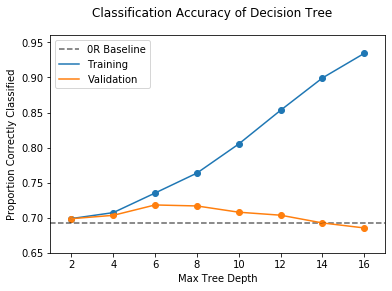

In [20]:
# Plot accuracy against depth

plt.plot(np.arange(1,18), 17*[0.692],
        alpha = 0.6, c = 'k', linestyle = 'dashed', label = '0R Baseline')
plt.scatter(dt_depth, dt_train)
plt.plot(dt_depth, dt_train, label = 'Training')
plt.plot(dt_depth, dt_test, label = 'Validation')
plt.scatter(dt_depth, dt_test)
plt.xlim(1,17)
plt.xticks(np.arange(2,17,2))
plt.ylim(0.65,0.96)
plt.xlabel('Max Tree Depth')
plt.ylabel ('Proportion Correctly Classified')
plt.legend(loc='upper left')
plt.suptitle('Classification Accuracy of Decision Tree')
#plt.savefig('DTAcc30.png', dpi=100)

In [21]:
print('Finding confusion matrix of best tree with depth', dt_depth[bestdt])
dt = DecisionTreeClassifier(max_depth=dt_depth[bestdt], criterion='gini', splitter='best', random_state = global_seed)
dt.fit(X_train, y_train)
confusion_matrix(y_test, dt.predict(X_test))

Finding confusion matrix of best tree with depth 6


array([[  41,  181,  247],
       [  15,  441,  804],
       [  15,  320, 3550]], dtype=int64)

In [22]:
# Get frequency of ratings in validation set
print('Ratings in validation:', np.unique(y_test, return_counts=True))

# Get frequency of ratings predicted
print('Ratings predicted:', np.unique(dt.predict(X_test), return_counts=True))

Ratings in validation: (array([1, 3, 5], dtype=int64), array([ 469, 1260, 3885], dtype=int64))
Ratings predicted: (array([1, 3, 5], dtype=int64), array([  71,  942, 4601], dtype=int64))


In [23]:
print('Getting detailed performance metrics...')

precision_recall_fscore_support(y_test, dt.predict(X_test))

Getting detailed performance metrics...


(array([0.57746479, 0.46815287, 0.7715714 ]),
 array([0.08742004, 0.35      , 0.91377091]),
 array([0.15185185, 0.40054496, 0.83667217]),
 array([ 469, 1260, 3885], dtype=int64))

## Model Variance

In [24]:
depth = dt_depth[bestdt] # 6

# To store result
dt_train = []
dt_test = []

In [25]:
# Verify that the data is as expected:
# ~22,454 training samples and around 80,000 features
# (varies since text features are genereated after different splits)
print(X_train.shape, y_train.shape)

# Build model

for seed in np.arange(40,45):
    X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, seed)
    
    dt = DecisionTreeClassifier(max_depth=depth, criterion='gini', splitter='best',
                               random_state= seed)
    dt.fit(X_train, y_train)
    
    dt_train.append(dt.score(X_train, y_train))
    dt_test.append(dt.score(X_test, y_test))

(22454, 84191) (22454,)
Seed is: 40
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49281) (5614, 49281)
2-gram features intially generated: (22454, 730743) (5614, 730743)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4965) (5614, 4965)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84458)
Final validation data: (5614, 84458)
Seed is: 41
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 48913) (5614, 48913)
2-gram features intially generated: (22454, 724899) (5614, 724899)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4874) (5614, 4874)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 83999)
Final val

In [26]:
print('Validation accuracy of 5 more models:', dt_test)
print('Mean accuracy:', np.mean(dt_test))
print('Std accuracy:', np.std(dt_test))

Validation accuracy of 5 more models: [0.7253295333095832, 0.7075169219807623, 0.7121482009262557, 0.7116138225863912, 0.7203420021375133]
Mean accuracy: 0.7153900961881011
Std accuracy: 0.006481832798315164


# Logistic Regression

## Model Construction

In [27]:
X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, global_seed=30)

Seed is: 30
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49049) (5614, 49049)
2-gram features intially generated: (22454, 729322) (5614, 729322)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4930) (5614, 4930)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84191)
Final validation data: (5614, 84191)


In [28]:
lreg_reg = [0.001, 0.0031, 0.01, 0.031, 0.1, 0.31, 1]
lreg_train = []
lreg_test = []

In [29]:
for c_ in lreg_reg:
    lreg = LogisticRegression(penalty = 'l2', C = c_, random_state= global_seed,
                             multi_class='ovr')
    lreg.fit(X_train, y_train)
    
    lreg_train.append(lreg.score(X_train, y_train))
    lreg_test.append(lreg.score(X_test, y_test))

C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Validation Results

In [30]:
# All results
for a,b,c in zip(lreg_reg, lreg_train, lreg_test):
    print('c = {}, train acc = {}, test acc = {}'.format(a,b,c))

c = 0.001, train acc = 0.8500489890442683, test acc = 0.8377271107944425
c = 0.0031, train acc = 0.8766366794335085, test acc = 0.8571428571428571
c = 0.01, train acc = 0.9071434933642113, test acc = 0.871571072319202
c = 0.031, train acc = 0.9405896499510109, test acc = 0.8758460990381189
c = 0.1, train acc = 0.9702502894807161, test acc = 0.8785179907374421
c = 0.31, train acc = 0.9878863454172976, test acc = 0.8786961168507303
c = 1, train acc = 0.9963035539324842, test acc = 0.8756679729248308


In [31]:
# Best result
bestlreg = np.argmax(lreg_test)
print('Best result has c = {}, train acc = {}, validation acc = {}'.format(lreg_reg[bestlreg],
                                                                                   lreg_train[bestlreg],
                                                                                   lreg_test[bestlreg]))

Best result has c = 0.31, train acc = 0.9878863454172976, validation acc = 0.8786961168507303


Text(0.5, 0.98, 'Classification Accuracy of Logistic Regression')

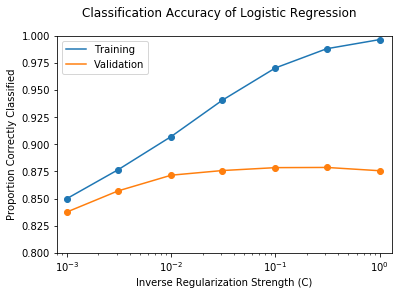

In [32]:
plt.scatter(lreg_reg, lreg_train)
plt.plot(lreg_reg, lreg_train, label = 'Training')
plt.plot(lreg_reg, lreg_test, label = 'Validation')
plt.scatter(lreg_reg, lreg_test)
plt.xscale('log')
plt.xlim(0.0008, 1.3)
plt.ylim(0.80,1)
plt.xlabel('Inverse Regularization Strength (C)')
plt.ylabel ('Proportion Correctly Classified')
plt.legend()
plt.suptitle('Classification Accuracy of Logistic Regression')
#plt.savefig('LREGAcc30.png', dpi=100)

In [33]:
print('Finding confusion matrix of logistic regression model with best regularisation parameter', lreg_reg[bestlreg])

lreg = LogisticRegression(penalty = 'l2', C = lreg_reg[bestlreg], random_state= global_seed)
lreg.fit(X_train, y_train)
    
confusion_matrix(y_test, lreg.predict(X_test))

Finding confusion matrix of logistic regression model with best regularisation parameter 0.31


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[ 308,   99,   62],
       [  44,  902,  314],
       [  12,  150, 3723]], dtype=int64)

In [34]:
# Get frequency of ratings in validation set
print('Ratings in validation:', np.unique(y_test, return_counts=True))

# Get frequency of ratings predicted
print('Ratings predicted:', np.unique(lreg.predict(X_test), return_counts=True))

Ratings in validation: (array([1, 3, 5], dtype=int64), array([ 469, 1260, 3885], dtype=int64))
Ratings predicted: (array([1, 3, 5], dtype=int64), array([ 364, 1151, 4099], dtype=int64))


In [35]:
print('Getting detailed performance metrics...')

precision_recall_fscore_support(y_test, lreg.predict(X_test))

Getting detailed performance metrics...


(array([0.84615385, 0.78366638, 0.90827031]),
 array([0.65671642, 0.71587302, 0.95830116]),
 array([0.7394958 , 0.74823725, 0.93261523]),
 array([ 469, 1260, 3885], dtype=int64))

## Model Variance

In [36]:
print(lreg_reg[bestlreg]) #0.31
lreg_train = []
lreg_test = []

0.31


In [37]:
# Verify that the data is as expected:
# ~22,454 training samples and around 80,000 features
# (varies since text features are genereated after different splits)
print(X_train.shape, y_train.shape)

# Build model

for seed in np.arange(40,45):
    X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, seed)
    
    lreg = LogisticRegression(penalty = 'l2', C = 0.31, 
                              random_state= seed)
    lreg.fit(X_train, y_train)
    
    lreg_train.append(lreg.score(X_train, y_train))
    lreg_test.append(lreg.score(X_test, y_test))

(22454, 84191) (22454,)
Seed is: 40
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49281) (5614, 49281)
2-gram features intially generated: (22454, 730743) (5614, 730743)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4965) (5614, 4965)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84458)
Final validation data: (5614, 84458)


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Seed is: 41
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 48913) (5614, 48913)
2-gram features intially generated: (22454, 724899) (5614, 724899)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4874) (5614, 4874)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 83999)
Final validation data: (5614, 83999)


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Seed is: 42
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49185) (5614, 49185)
2-gram features intially generated: (22454, 726390) (5614, 726390)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4946) (5614, 4946)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84343)
Final validation data: (5614, 84343)


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Seed is: 43
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 48908) (5614, 48908)
2-gram features intially generated: (22454, 727171) (5614, 727171)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4935) (5614, 4935)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84055)
Final validation data: (5614, 84055)


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Seed is: 44
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49145) (5614, 49145)
2-gram features intially generated: (22454, 729321) (5614, 729321)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4960) (5614, 4960)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84317)
Final validation data: (5614, 84317)


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [38]:
print('Validation accuracy of 5 more models:', lreg_test)
print('Mean accuracy:', np.mean(lreg_test))
print('Std accuracy:', np.std(lreg_test))

Validation accuracy of 5 more models: [0.8829711435696473, 0.8797648735304595, 0.8770929818311365, 0.8794086213038832, 0.8795867474171714]
Mean accuracy: 0.8797648735304596
Std accuracy: 0.0018749835934365156


# Support Vector Classifier

## Model Construction

In [39]:
X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, global_seed=30)

Seed is: 30
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49049) (5614, 49049)
2-gram features intially generated: (22454, 729322) (5614, 729322)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4930) (5614, 4930)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84191)
Final validation data: (5614, 84191)


In [40]:
svm_reg = [0.001,0.0031,0.01,0.031,0.1,0.31,1]
svm_train = []
svm_test = []

In [41]:
print("Seed:", global_seed)

for c_ in svm_reg:
    svmlin = svm.LinearSVC(C = c_, max_iter=3000, random_state= global_seed)
    svmlin.fit(X_train, y_train)
    svm_train.append(svmlin.score(X_train, y_train))
    svm_test.append(svmlin.score(X_test, y_test))

Seed: 30


C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Validation Results

In [42]:
# All results
for a,b,c in zip(svm_reg, svm_train, svm_test):
    print('c = {}, train acc = {}, test acc = {}'.format(a,b,c))

c = 0.001, train acc = 0.9111516878952525, test acc = 0.8705023156394728
c = 0.0031, train acc = 0.9452658769038924, test acc = 0.8754898468115426
c = 0.01, train acc = 0.9742139485169681, test acc = 0.8769148557178482
c = 0.031, train acc = 0.9898013716932396, test acc = 0.8774492340577129
c = 0.1, train acc = 0.9971051928386925, test acc = 0.871571072319202
c = 0.31, train acc = 0.9993765030729491, test acc = 0.8639116494478091
c = 1, train acc = 0.9999109290104213, test acc = 0.8592803705023156


In [43]:
# Best result
bestsvm = np.argmax(svm_test)
print('Best result has c = {}, train acc = {}, validation acc = {}'.format(svm_reg[bestsvm],
                                                                                   svm_train[bestsvm],
                                                                                   svm_test[bestsvm]))

Best result has c = 0.031, train acc = 0.9898013716932396, validation acc = 0.8774492340577129


Text(0.5, 0.98, 'Classification Accuracy of Support Vector Classifier')

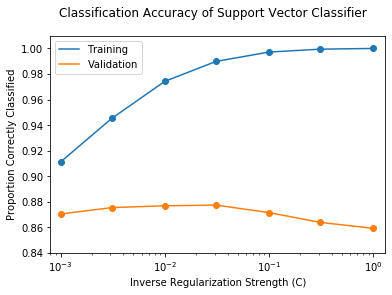

In [44]:
plt.scatter(svm_reg, svm_train)
plt.plot(svm_reg, svm_train, label = 'Training')
plt.plot(svm_reg, svm_test, label = 'Validation')
plt.scatter(svm_reg, svm_test)
plt.xscale('log')
plt.ylim(0.84,1.01)
plt.xlim(0.0008,1.3)
plt.xlabel('Inverse Regularization Strength (C)')
plt.ylabel ('Proportion Correctly Classified')
plt.legend()
plt.suptitle('Classification Accuracy of Support Vector Classifier')
#plt.savefig('SVMAcc30.png', dpi=100)

In [45]:
print('Finding confusion matrix of SVM with best regularisation parameter', svm_reg[bestsvm])

svmlin = svm.LinearSVC(C = svm_reg[bestsvm], max_iter=2000, random_state= global_seed)
svmlin.fit(X_train, y_train)
    
confusion_matrix(y_test, svmlin.predict(X_test))

Finding confusion matrix of SVM with best regularisation parameter 0.031


array([[ 311,   96,   62],
       [  52,  905,  303],
       [  14,  161, 3710]], dtype=int64)

In [46]:
# Get frequency of ratings in validation set
print('Ratings in validation:', np.unique(y_test, return_counts=True))

# Get frequency of ratings predicted
print('Ratings predicted:', np.unique(svmlin.predict(X_test), return_counts=True))

Ratings in validation: (array([1, 3, 5], dtype=int64), array([ 469, 1260, 3885], dtype=int64))
Ratings predicted: (array([1, 3, 5], dtype=int64), array([ 377, 1162, 4075], dtype=int64))


In [47]:
# Detailed performance metrics

print('Getting detailed performance metrics...')
precision_recall_fscore_support(y_test, svmlin.predict(X_test))

Getting detailed performance metrics...


(array([0.82493369, 0.7788296 , 0.91042945]),
 array([0.66311301, 0.71825397, 0.95495495]),
 array([0.73522459, 0.74731627, 0.9321608 ]),
 array([ 469, 1260, 3885], dtype=int64))

## Model Variance

In [48]:
print(svm_reg[bestsvm]) #0.031
svm_train = []
svm_test = []

0.031


In [49]:
# Build model

for seed in np.arange(40,45):
    X_train, X_test, y_train, y_test = create_random_split(d2v200_train, 
                                                       review_meta_train, 
                                                       review_text_train, seed)
    
    svmlin = svm.LinearSVC(C = svm_reg[bestsvm], 
                           max_iter=2000, 
                           random_state= seed)
    svmlin.fit(X_train, y_train)
    
    svm_train.append(svmlin.score(X_train, y_train))
    svm_test.append(svmlin.score(X_test, y_test))

Seed is: 40
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 49281) (5614, 49281)
2-gram features intially generated: (22454, 730743) (5614, 730743)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4965) (5614, 4965)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 84458)
Final validation data: (5614, 84458)
Seed is: 41
X_train: (22454, 203) y_train: (22454,) 
X_test: (5614, 203) y_test: (5614,)
review_train: (22454, 1) y_train: (22454,) 
review_test: (5614, 1) y_test: (5614,)
1-gram features: (22454, 48913) (5614, 48913)
2-gram features intially generated: (22454, 724899) (5614, 724899)
2-gram features: (22454, 30000) (5614, 30000)
Exclamation features: (22454, 4874) (5614, 4874)
Explicit Mentions features: (22454, 9) (5614, 9)
Final training data: (22454, 83999)
Final validation data: (5614, 839

In [50]:
print('Validation accuracy of 5 more models:', lreg_test)
print('Mean accuracy:', np.mean(lreg_test))
print('Std accuracy:', np.std(lreg_test))

Validation accuracy of 5 more models: [0.8829711435696473, 0.8797648735304595, 0.8770929818311365, 0.8794086213038832, 0.8795867474171714]
Mean accuracy: 0.8797648735304596
Std accuracy: 0.0018749835934365156


# Results (No need to run this part)

In [51]:
# Retrieve labels
y_train = review_meta_train['rating'].to_numpy()

X_train = hstack((d2v200_train,
                  review_meta_train[['vote_cool', 'vote_funny', 'vote_useful']]))

X_test = hstack((d2v200_test,
                 review_meta_test[['vote_cool', 'vote_funny', 'vote_useful']]))

countvect = CountVectorizer(lowercase = False)
countvect_2gram = CountVectorizer(lowercase = False, ngram_range=(2,2))
countvect_explicit = CountVectorizer(lowercase = False, ngram_range=(1,1), 
                                     binary=False,
                                     token_pattern='\s\d\sstar')
countvect_exclaim = CountVectorizer(lowercase = False, token_pattern='\w+\!')

unigram_train = countvect.fit_transform(review_text_train['review'])
unigram_test = countvect.transform(review_text_test['review'])
print('1-gram features:', unigram_train.shape, unigram_test.shape)

bigram_train = countvect_2gram.fit_transform(review_text_train['review'])
bigram_test = countvect_2gram.transform(review_text_test['review'])
print('2-gram features intially generated:', bigram_train.shape, bigram_test.shape)

selection = SelectKBest(k=30000)
bigram_train = selection.fit_transform(bigram_train, y_train)
bigram_test = selection.transform(bigram_test)

print('2-gram features:', bigram_train.shape, bigram_test.shape)

exclaim_train = countvect_exclaim.fit_transform(review_text_train['review'])
exclaim_test = countvect_exclaim.transform(review_text_test['review'])
print('Exclamation features:', exclaim_train.shape, exclaim_test.shape)

explicit_train = countvect_explicit.fit_transform(review_text_train['review'])
explicit_test = countvect_explicit.transform(review_text_test['review'])
print('Explicit Mentions features:', explicit_train.shape, explicit_test.shape)

# Merge all features

X_train = hstack((X_train, unigram_train, bigram_train, exclaim_train, explicit_train))
X_test = hstack((X_test, unigram_test, bigram_test, exclaim_test, explicit_test))

print('Final training data:', X_train.shape)
print('Final testing data:', X_test.shape)

1-gram features: (28068, 54325) (7018, 54325)
2-gram features intially generated: (28068, 853711) (7018, 853711)
2-gram features: (28068, 30000) (7018, 30000)
Exclamation features: (28068, 5607) (7018, 5607)
Explicit Mentions features: (28068, 9) (7018, 9)
Final training data: (28068, 90144)
Final testing data: (7018, 90144)


In [52]:
baseline_0r = DummyClassifier(strategy='most_frequent')
baseline_0r.fit(X_train, y_train)
zerorpreds = baseline_0r.predict(X_test)

In [53]:
dt = DecisionTreeClassifier(max_depth=dt_depth[bestdt], criterion='gini', splitter='best', random_state = global_seed)
dt.fit(X_train, y_train)
dtpreds = dt.predict(X_test)

In [54]:
lreg = LogisticRegression(penalty = 'l2', C = lreg_reg[bestlreg], random_state= global_seed)
lreg.fit(X_train, y_train)
    
lregpreds = lreg.predict(X_test)

C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c33041440\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [55]:
svmlin = svm.LinearSVC(C = svm_reg[bestsvm], max_iter=2000, random_state= global_seed)
svmlin.fit(X_train, y_train)
    
svmpreds = svmlin.predict(X_test)

In [62]:
# for file, pred in zip(['submit_0r.csv', 'submit_dt.csv', 'submit_logreg.csv', 'submit_svm.csv'], [zerorpreds, dtpreds, lregpreds,svmpreds]):
#     results = pd.DataFrame({'Instance_id': np.arange(1,len(zerorpreds)+1),
#                             'rating': pred})
#     results.to_csv(file, index=False)
#     print(results.shape)

(7018, 2)
(7018, 2)
(7018, 2)
(7018, 2)
